In [51]:
import cartopy.crs as ccrs
import hvplot.xarray
import xarray as xr
import requests
from glob import glob
import pandas as pd
from herbie import Herbie
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import thread_map
wave_wind_mapping = {
    # Combined Wave Parameters
    "Hsig": "HTSGW",       # Hsig: Significant wave height -> HTSGW: Significant Height of Combined Wind Waves and Swell
    "PkDir": "DIRPW",      # PkDir: Peak wave direction -> DIRPW: Direction of Combined Wind Waves and Swell (Often peak direction is reported as the primary direction)
    "Tm01": "PERPW",       # Tm01: Mean wave period (m01) -> PERPW: Mean Period of Combined Wind Waves and Swell (Tm01 is a common representation for mean period)
    # Wind Parameters
    #"Windv_x": "UGRD",     # Windv_x: Horizontal component of wind velocity -> UGRD: U-component of wind
    #"Windv_y": "VGRD",     # Windv_y: Vertical component of wind velocity (Likely intended as the other horizontal component) -> VGRD: V-component of wind
}

In [2]:
# Temporal extent: 20000108-20191231
H = Herbie("20000108", model="gefs_wave_reforecast", member=0, save_dir="./GEFS")

✅ Found ┊ model=gefs_wave_reforecast ┊ product=GEFSv12/wave_reforecast ┊ 2000-Jan-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


In [3]:
H.inventory("HTSGW").head(10)

,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
4,5,2764492,3152083.0,2764492-3152083,2000-01-08 03:00:00,2000-01-08 03:00:00,HTSGW,surface,anl,:HTSGW:surface:anl
26,27,15711012,16094573.0,15711012-16094573,2000-01-08 03:00:00,2000-01-08 03:00:00,HTSGW,surface,3 hour fcst,:HTSGW:surface:3 hour fcst
48,49,28674398,29058026.0,28674398-29058026,2000-01-08 03:00:00,2000-01-08 03:00:00,HTSGW,surface,6 hour fcst,:HTSGW:surface:6 hour fcst
70,71,41685615,42069858.0,41685615-42069858,2000-01-08 03:00:00,2000-01-08 03:00:00,HTSGW,surface,9 hour fcst,:HTSGW:surface:9 hour fcst
92,93,54743814,55128650.0,54743814-55128650,2000-01-08 03:00:00,2000-01-08 03:00:00,HTSGW,surface,12 hour fcst,:HTSGW:surface:12 hour fcst
114,115,67858693,68243804.0,67858693-68243804,2000-01-08 03:00:00,2000-01-08 03:00:00,HTSGW,surface,15 hour fcst,:HTSGW:surface:15 hour fcst
136,137,81043359,81429186.0,81043359-81429186,2000-01-08 03:00:00,2000-01-08 03:00:00,HTSGW,surface,18 hour fcst,:HTSGW:surface:18 hour fcst
158,159,94304200,94690499.0,94304200-94690499,2000-01-08 03:00:00,2000-01-08 03:00:00,HTSGW,surface,21 hour fcst,:HTSGW:surface:21 hour fcst
180,181,107607135,107995457.0,107607135-107995457,2000-01-08 03:00:00,2000-01-08 03:00:00,HTSGW,surface,24 hour fcst,:HTSGW:surface:24 hour fcst
202,203,120941881,121331251.0,120941881-121331251,2000-01-08 03:00:00,2000-01-08 03:00:00,HTSGW,surface,27 hour fcst,:HTSGW:surface:27 hour fcst


In [157]:
def download_GEFS(date):
    H = Herbie(date, model="gefs_wave_reforecast", member=0, save_dir="./GEFS")
    ds = H.xarray(rf":(?:HTSGW|DIRPW|PERPW):surface:(?:anl|(?:3|6|9|12|15|18|21) hour fcst)")
    ds = ds.sel(longitude=slice(165, 180), latitude=slice(-33,-48))
    ds = ds.drop_vars("time").rename({"step": "time"}).assign_coords(time=ds.valid_time.values).drop_vars(["gribfile_projection", "surface", "valid_time"])
    return ds

dsets = thread_map(
    download_GEFS,
    pd.date_range("2000-01-08", "2000-01-10", freq="D"),
    max_workers=8,
    desc="Downloading GEFS data",
    unit="day",
)
dsets = xr.concat(dsets, dim="time")
dsets

✅ Found✅ Found ┊ model=gefs_wave_reforecast ┊ product=GEFSv12/wave_reforecast ┊ 2000-Jan-08 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
 ┊ model=gefs_wave_reforecast ┊ product=GEFSv12/wave_reforecast ┊ 2000-Jan-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs_wave_reforecast ┊ product=GEFSv12/wave_reforecast ┊ 2000-Jan-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/mnt/data/physicsnemo/.venv/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/mnt/data/physicsnemo/.venv/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/mnt/data/physicsnemo/.venv/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coo

<xarray.Dataset> Size: 1MB
Dimensions:    (time: 24, latitude: 61, longitude: 60)
Coordinates:
  * latitude   (latitude) float64 488B -33.0 -33.25 -33.5 ... -47.5 -47.75 -48.0
  * longitude  (longitude) float64 480B 165.0 165.3 165.5 ... 179.3 179.5 179.8
  * time       (time) datetime64[ns] 192B 2000-01-08T03:00:00 ... 2000-01-11
Data variables:
    swh        (time, latitude, longitude) float32 351kB 1.87 1.87 ... 2.91 2.94
    dirpw      (time, latitude, longitude) float32 351kB 255.7 255.5 ... 233.2
    perpw      (time, latitude, longitude) float32 351kB 9.04 9.07 ... 12.81
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   gefs_wave_reforecast
    product:                 GEFSv12/wave_reforecast
    description:             NOAA Wave Ensemble Reforecast
    remote_grib:             https://noaa-nws-gefswaves-reforecast-pds.s3.ama...
    local_grib:              GEFS/gefs_wave_reforecast/20000108/subset_b4ef68...
    search:                  :(?:HTSGW|DIRPW|PERPW):surface:(?:anl|(?:3|6|9|1...

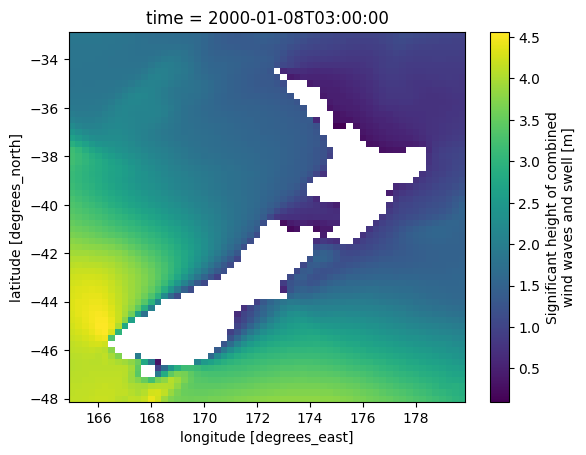

In [158]:
dsets.swh[0].plot()

In [159]:
dsets.swh.hvplot(
    groupby="time",
    widget_type="scrubber",
    widget_location="bottom",
    clim=(0, 4.5),
    width=500,
    cmap="spectral_r",
    geo=True,
    coastline=True
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'652958f6-c80d-495b-bc58-7a8e969019ae': {'version…